In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

In [3]:
data = pd.read_csv('data.csv')
data

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425000,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.250000,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237541,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.20,1.80,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,29.00,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440000,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.200000,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.10,1.90,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,26.00,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425000,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.250000,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237541,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,1667.383429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.10,1.90,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,19.00,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,53.639405,775.425000,1010.544286,718.152900,938.512777,1.305967,0.783207,810.6,739.575000,323.811808,355.183884,160.250000,105.100000,136.126003,84.371352,1.259244,1.173033,205,46.114286,75.237541,68.521665,4654.35725,2980.330857,724.953211,53.758486,1.033129,0.788889,8958.571,1623.483429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.15,1.85,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,22.00,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,53.588771,775.425000,1009.717143,718.152900,937.025573,1.305967,0.805230,810.6,728.807143,323.811808,356.319281,160.250000,106.342857,136.126003,84.843442,1.259244,1.261194,205,36.514286,75.237541,70.634448,4654.35725,2923.845143,724.953211,53.117029,1.033129,0.859811,8958.571,1491.783429,3306.162897,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.30,1.70,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,23.00,Ba0.3La1.7Cu1O4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [4]:
x, y = data.values[:, :-2].astype(np.float32), data.values[:, -2:-1].astype(np.float32)

np.random.seed(1337)
is_train = np.random.uniform(size=(x.shape[0],)) < 0.95

x_train, y_train = x[is_train], y[is_train]
x_test, y_test = x[~is_train], y[~is_train]

print(f'Train samples: {len(x_train)}')
print(f'Test samples: {len(x_test)}')

Train samples: 20210
Test samples: 1053


In [5]:
class PolynomialRegression:
    def __init__(
        self,
        alpha1,
        alpha2,
        poly_deg,
        learning_rate,
        batch_size,
        train_steps
    ):
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.poly_deg = poly_deg
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_steps = train_steps
    
    def preprocess(self, x):
        size_y, _ = x.shape
        x_proc = np.ones((size_y, 1))
        for i in range(self.poly_deg):
            x_proc = np.concatenate([
                  x_proc,
                  x ** (i + 1)
            ], axis = 1)
        return x_proc

    def mse(self, x, y, theta, n):
        return np.sum((x @ theta - y) ** 2) / n
    
    def normalize(self, x):
        mean, std = self.moments(x)
        X_tmp = (x - mean) / (std + 1e-10)
        
        return X_tmp
    
    def count_mean_deviation(self, x):
        mean_deviations = []
        for array in x.T:
          mean = np.mean(array)
          deviations = np.absolute(array - mean)
          sum = np.sum(deviations) / deviations.shape[0]
          mean_deviations.append(sum)
        return np.array(mean_deviations).T
          

    def moments(self, x):
        # mean = self.count_mean_deviation(x[:, 1:])
        mean = np.mean(x[:, 1:], axis=0)
        std = np.std(x[:, 1:], axis=0)
        
        return np.append([0], mean), np.append([1], std)
    
    def J(self, x, y, theta):
        theta_shlyapa = np.delete(theta, 0, 0)
        return self.mse(x, y, theta, y.shape[0]) + self.alpha1 * np.sum(np.absolute(theta_shlyapa)) + self.alpha2 * np.sum(theta_shlyapa ** 2)
    
    def grad(self, x, y, theta):
        diag = np.zeros((x.shape[1], x.shape[1]), int)
        np.fill_diagonal(diag, 1)
        return -2 * x.T @ (y - x @ theta) / x.shape[0] + diag @ (self.alpha1 * np.sign(theta) + 2 * self.alpha2 * theta)
    
    def get_batch(self, x, y):
        indices = np.random.choice(x.shape[0], self.batch_size, replace=False)
        X_res = x[indices[0]].reshape(1, x.shape[1])
        Y_res = y[indices[0]].reshape(1, y.shape[1])
        
        for i in range(1, self.batch_size):
            X_res = np.append(X_res, x[indices[i]].reshape(1, x.shape[1]), axis=0)
            Y_res = np.append(Y_res, y[indices[i]].reshape(1, y.shape[1]), axis=0)
        
        return X_res, Y_res
    
    def fit(self, x, y):
        x = self.preprocess(x)
        (m, N), (_, k) = x.shape, y.shape
        
        self.mu, self.sigma = self.moments(x)
        x = self.normalize(x)
        
        try:
            assert np.allclose(x[:, 1:].mean(axis=0), 0, atol=1e-3)
            assert np.all((np.abs(x[:, 1:].std(axis=0)) < 1e-2) | (np.abs(x[:, 1:].std(axis=0) - 1) < 1e-2))
        except AssertionError as e:
            print('Something wrong with normalization')
            raise e
            
        x_batch, y_batch = self.get_batch(x, y)
        try:
            assert x_batch.shape[0] == self.batch_size
            assert y_batch.shape[0] == self.batch_size
        except AssertionError as e:
            print('Something wrong with get_batch')
            raise e
        
        theta = np.zeros(shape=(N, k))
        v_1 = theta
        v_t = v_1
        for step in range(self.train_steps):
            x_batch, y_batch = self.get_batch(x, y)
            theta_grad = self.grad(x_batch, y_batch, theta)

            # TODO Update v_t and theta
            v_t = 0.9 * v_t + self.learning_rate * theta_grad
            theta = theta - v_t
            
        self.theta = theta
        
        return self

    def predict(self, x):
        x = self.preprocess(x)
        x = self.normalize(x)
        return x @ self.theta
    
    def score(self, x, y):
        y_pred = self.predict(x)
        return np.abs(y - y_pred).mean()

In [81]:
reg = PolynomialRegression(0, 0, 1, 1e-3, 1024, 1000).fit(x_train, y_train)
print(f'Test MAE: {reg.score(x_test, y_test)}')

Test MAE: 12.7258396327213


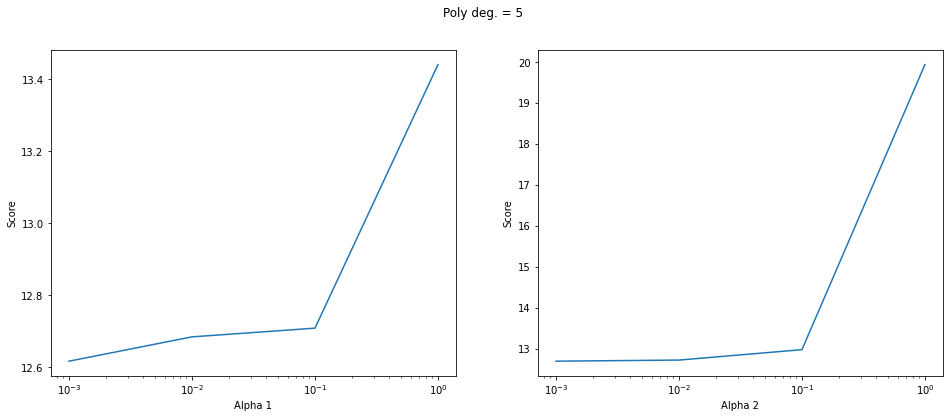

In [91]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle('Poly deg. = 5')
ax[0].set_xlabel('Alpha 1')
ax[0].set_ylabel('Score')
ax[0].set_xscale('log')
ax[0].plot([1e-3, 1e-2, 1e-1, 1], [
                                   PolynomialRegression(1e-3, 0, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test), 
                                   PolynomialRegression(1e-2, 0, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   PolynomialRegression(1e-1, 0, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   PolynomialRegression(1, 0, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test)
                                   ])
ax[1].set_xlabel('Alpha 2')
ax[1].set_ylabel('Score')
ax[1].set_xscale('log')
ax[1].plot([1e-3, 1e-2, 1e-1, 1], [
                                   PolynomialRegression(0, 1e-3, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test), 
                                   PolynomialRegression(0, 1e-2, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   PolynomialRegression(0, 1e-1, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test),
                                   PolynomialRegression(0, 1, 1, 1e-3, 1024, 1000).fit(x_train, y_train).score(x_test, y_test)
                                   ])
plt.show()

In [98]:
results = [[], [], [], []]
for a1 in enumerate([1e-3, 1e-2, 1e-1, 1]):
    for a2 in enumerate([1e-3, 1e-2, 1e-1, 1]):
        reg = PolynomialRegression(a1[1], a2[1], 1, 1e-3, 1024, 1000).fit(x_train, y_train)
        result = reg.score(x_test, y_test)
        results[a1[0]].append(result)


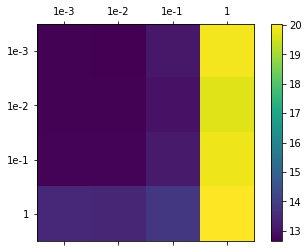

In [99]:
alphabets = ['1e-3', '1e-2', '1e-1', '1',]
 
figure = plt.figure()
axes = figure.add_subplot(111)
 
# using the matshow() function
caxes = axes.matshow(results, interpolation ='nearest')
figure.colorbar(caxes)
 
axes.set_xticklabels(['']+alphabets)
axes.set_yticklabels(['']+alphabets)
 
plt.show()

Test MAE: 12.724534680926793


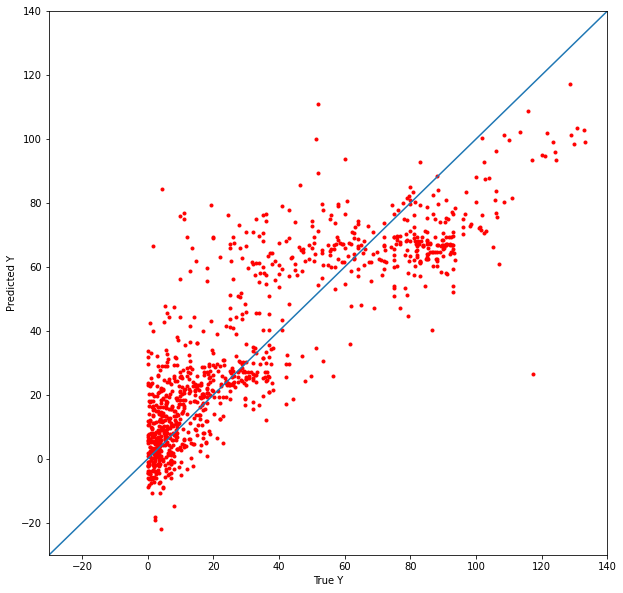

In [6]:
reg = PolynomialRegression(1e-3, 1e-3, 1, 1e-3, 1024, 1000).fit(x_train, y_train)
y_test_pred = reg.predict(x_test)
print(f'Test MAE: {reg.score(x_test, y_test)}')

plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test_pred[:, 0], marker='.', c='r')
plt.xlim(-30, 140)
plt.ylim(-30, 140)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')

t = np.linspace(-30, 140, 100)
plt.plot(t, t)

plt.show()